# Header

In [2]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
#%matplotlib notebook

import numpy as np
import scipy as s
import scipy.signal as sig

In [3]:
# Check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512'

# Functions

In [4]:
# returnm some important and used much values of the histogram
def histo_imp_val(rho, edge):
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    return nx,ny,nz,dx,dy,dz,centerx,centery,centerz

In [5]:
# Define single ptcl softened potential (softened green's function), given a density matrix shape
def soft_pot(rho,edge,a):
    pot =rho*0 #initialise potential matrix
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    for i in range(nx):
        for j in range(ny):
            for k in range(nz): # looking at some bin i,j,k
                x = (i+0.5)*dx-centerx # position of the center of the bin in x, given ptcl at x=0.5 (i.e at the center, since x=[0,1) )
                y = (j+0.5)*dy-centery
                z = (k+0.5)*dz-centerz
                r = np.sqrt(x**2+y**2+z**2) # distance btw center of bin and and particle
                if r**3<=a:
                    pot[i,j,k] = r/a # potential for bins close to ptcl
                else:
                    pot[i,j,k] = 1/r**2 # potential for bins far from ptcl
    return pot

In [6]:
# define function for easy visual check (thanks Marcus!)
def plot_2D_collapse(H,edges):
    edges_x = edges[0]
    edges_y = edges[1]
    edges_z = edges[2]
    fig,ax = plt.subplots(figsize=(10,10), dpi=100)
    im = ax.imshow(
        H.sum(axis=2),
        origin="lower",
        extent=(edges_y.min(), edges_y.max(), edges_x.min(), edges_x.max()), 
        aspect="auto")
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    minor_ticks_x = edges_x
    minor_ticks_y = edges_y
    ax.set(xlim=(minor_ticks_y[0], minor_ticks_y[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    ax.set_xticks(minor_ticks_y, minor=True)
    ax.set_yticks(minor_ticks_x, minor=True)

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show

In [17]:
#Return a 3D plot of the given x
def plot_graph3D(x, edge, title ="", scale_factor = 1,save=False, show = True, name = "fig",n = 0):
    #Create figure
    x = np.transpose(x)
    fig=plt.figure(figsize=(10,10))#Create 3D axes
    ax=Axes3D(fig) 
    ax.scatter(x[0], x[1], x[2], color="royalblue", marker=".",s=.02*scale_factor)
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_zlabel("z-coordinate",fontsize=14)
    ax.set_title(title,fontsize=20)
    #ax.legend(loc="upper left",fontsize=14)
    #ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([])
    #ax.zaxis.set_ticklabels([])
    ax.set_xlim3d(edge[0].min(),edge[0].max())
    ax.set_ylim3d(edge[1].min(),edge[1].max())
    ax.set_zlim3d(edge[2].min(),edge[2].max())
    if save:
        plt.savefig('Pictures_Final_Project/{}{}.png'.format(name,n), dpi=100)
    if show  == False:
        plt.close(fig)

In [8]:
# Allow to transform the rho nxnxn matrix to a nx3 matrix of all the points position,
# thus allowing us to plot it using plot_graph3D()
def rho_to_x(rho):
    x = np.array([[0,0,0]])
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    for i in range(nx):
        #print("i=",i) #Debugging
        for j in range(ny):
            for k in range(nz):
                if rho[i,j,k] != 0.:
                    for nb_ptcl in range(int(rho[i,j,k])):
                        position = np.array([[(i+0.5)*dx-centerx,(j+0.5)*dy-centery,(k+0.5)*dz-centerz]])# obtain position
                        x = np.concatenate((x,position),axis=0)# add it to the list of points x
                    
    return x[1:] #removes the first dummy point [0,0,0] and return x

In [9]:
# return the ijk coordinate of a given cell position
def x_to_ijk(cell_pos, rho, edge):
    nx,ny,nz,dx,dy,dz,cx,cy,cz = histo_imp_val(rho, edge)
    x = cell_pos[0]
    y = cell_pos[1]
    z = cell_pos[2]
    i = int((x+cx)/dx - 0.5)
    j = int((y+cy)/dy - 0.5)
    k = int((z+cz)/dz - 0.5)
    #print(i,j,k) #debugging
    return i,j,k

# Code

Initialization :
 -- COMPLETE --
Density rho :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --


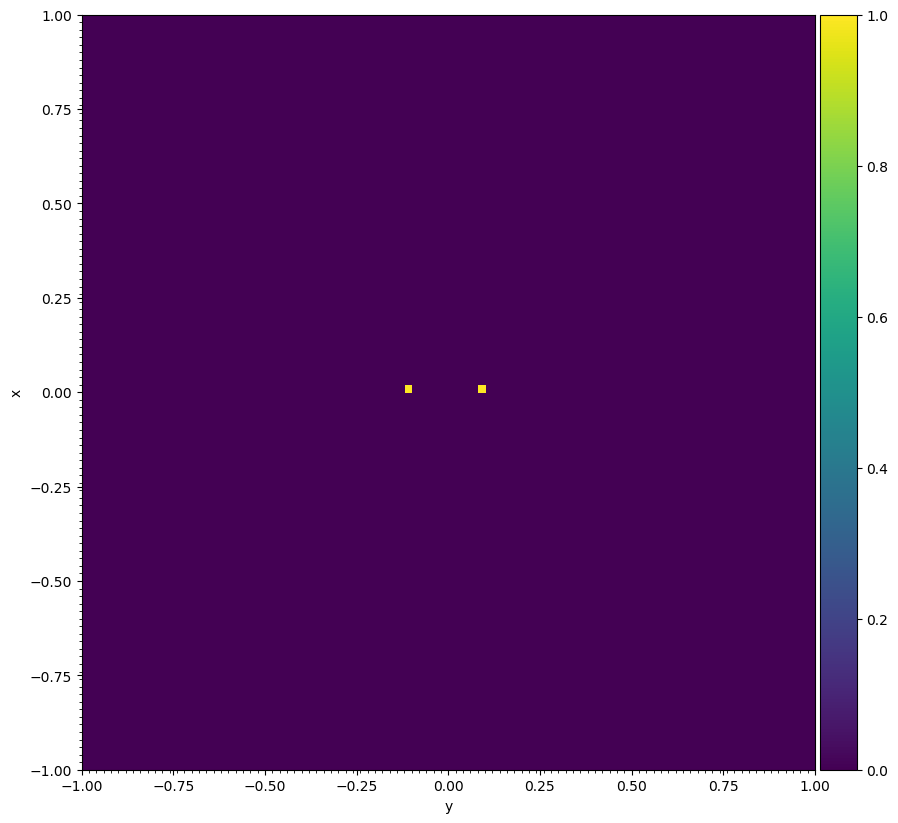

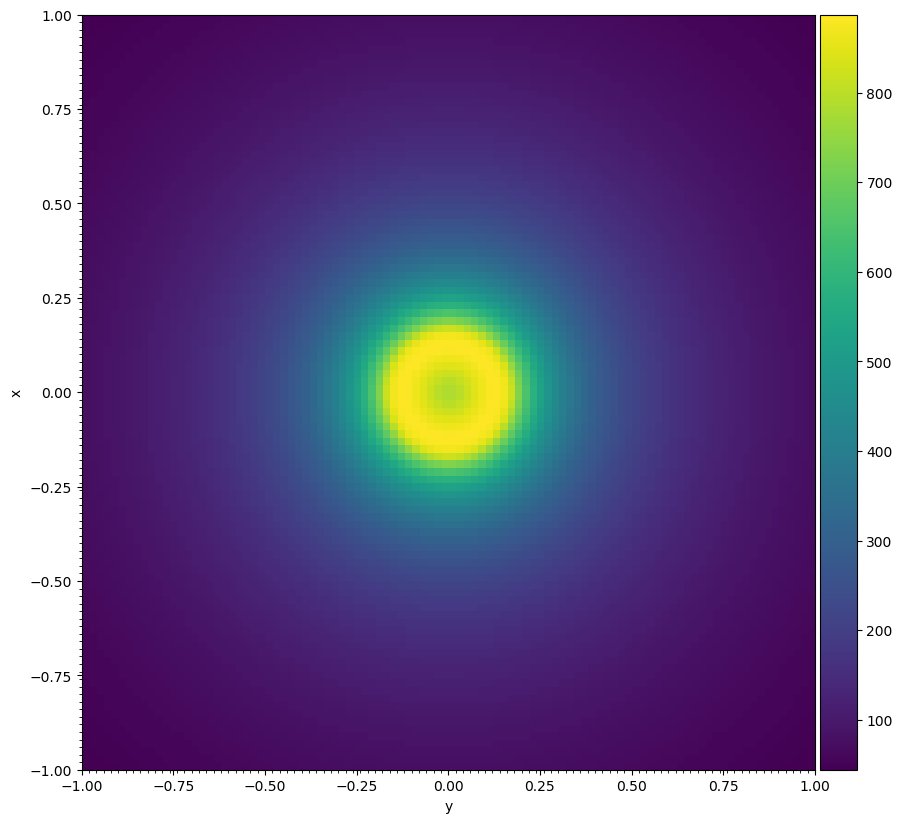

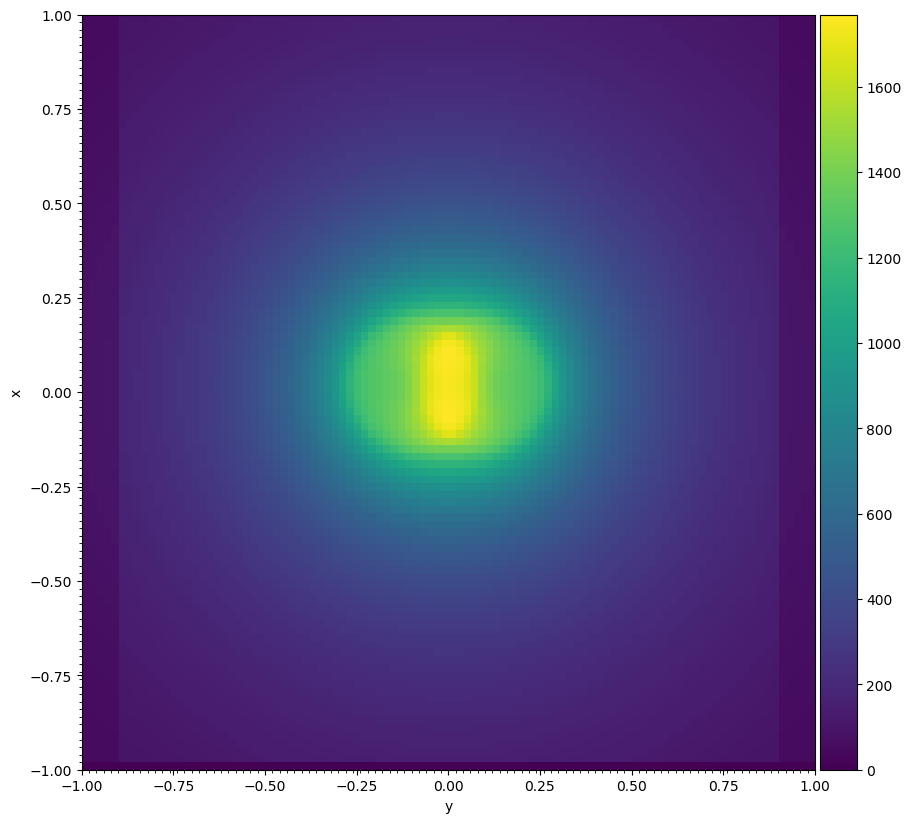

In [42]:
# initialise randomly for some n ptcls in a box size^3
print("Initialization :")
n = 2
size = 100
#x=np.random.rand(n,3)*2-1
x=np.array([[0,-0.1,0],[0,0.1,0]])
print(" -- COMPLETE --")

# Create density matrix rho
print("Density rho :")
rho,edge = np.histogramdd(x,bins=size,range=((-1,1),(-1,1),(-1,1)))
plot_2D_collapse(rho,edge)
print(" -- COMPLETE --")

# Create softened potential matrix s_pot
print("Green's Func :")
greens_f = soft_pot(rho,edge,0.005)
plot_2D_collapse(greens_f,edge)
print(" -- COMPLETE --")

# Compute total potential matrix by convolving the density matrix with the softened potential
print("Potential :")
#phi = np.fft.ifft(np.fft.fft(greens_f) * np.fft.fft(rho)) #Not working for some reason...
#phi = np.fft.fftshift(phi)
phi = sig.fftconvolve(rho,greens_f,mode='same')
plot_2D_collapse(phi,edge)
print(" -- COMPLETE --")

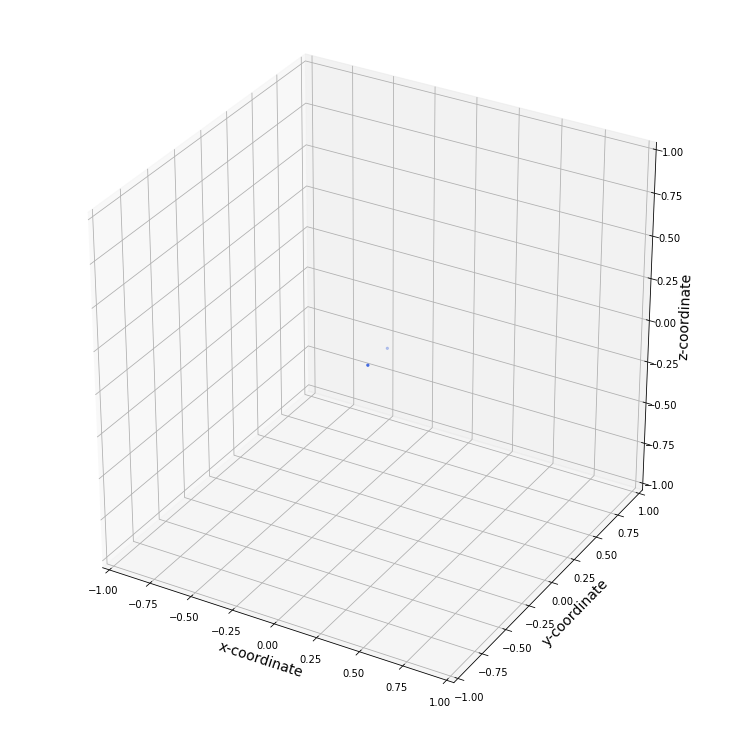

In [43]:
# initial image
rho_x = rho_to_x(rho)
plot_graph3D(rho_x,edge,scale_factor = 1000)

In [44]:
# Define timestep
dt = 0.005

# Compute the acceleration matrix by taking the gradient of the potential
acc_n = np.transpose(np.gradient(phi))
v_0 = acc_n*0
v_n = v_0 + 0.5*acc_n
v_n1 = v_n*0
rho_n = rho
rho_n1 = rho_n*0

Step : 1
Step : 2
Step : 3
Step : 4
Step : 5
Step : 6
Step : 7
Step : 8
Step : 9
Step : 10


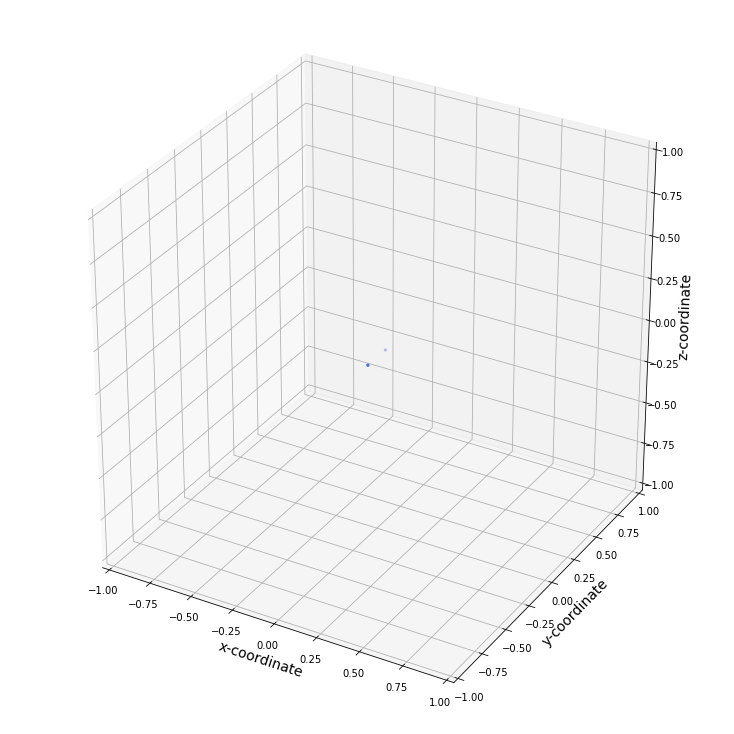

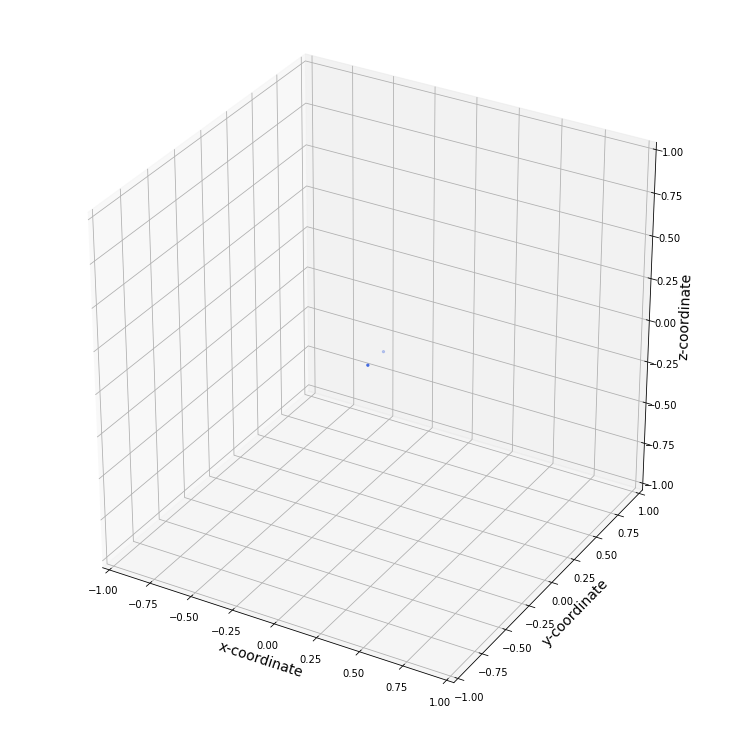

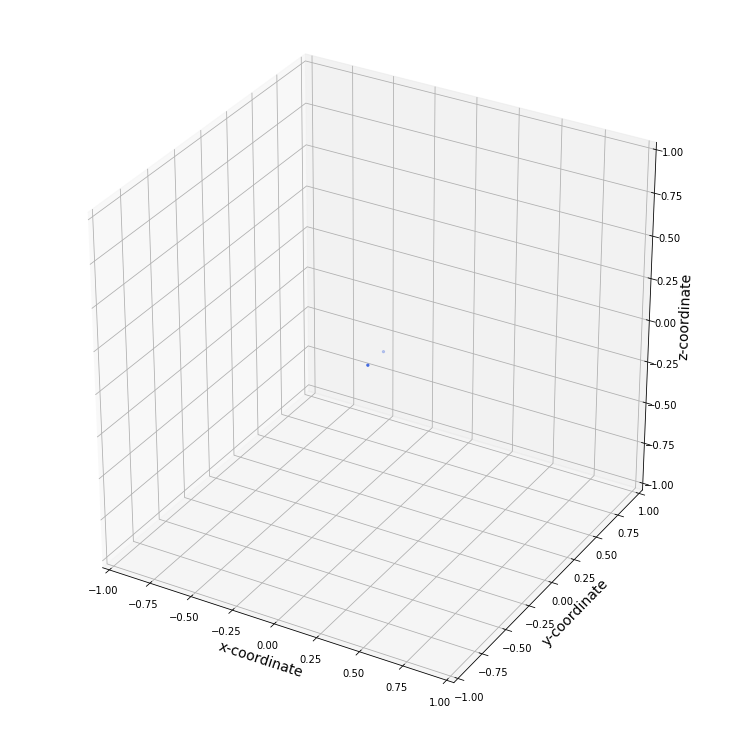

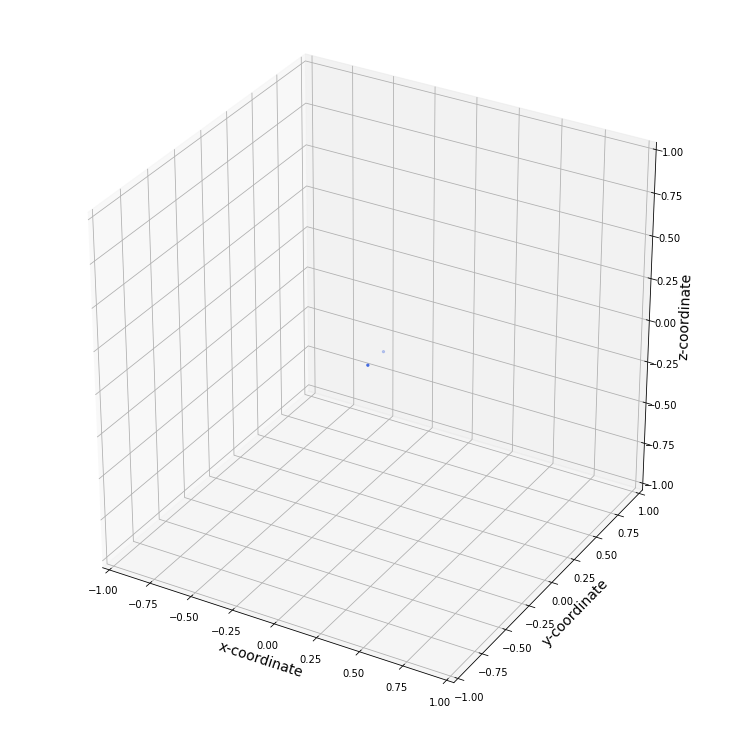

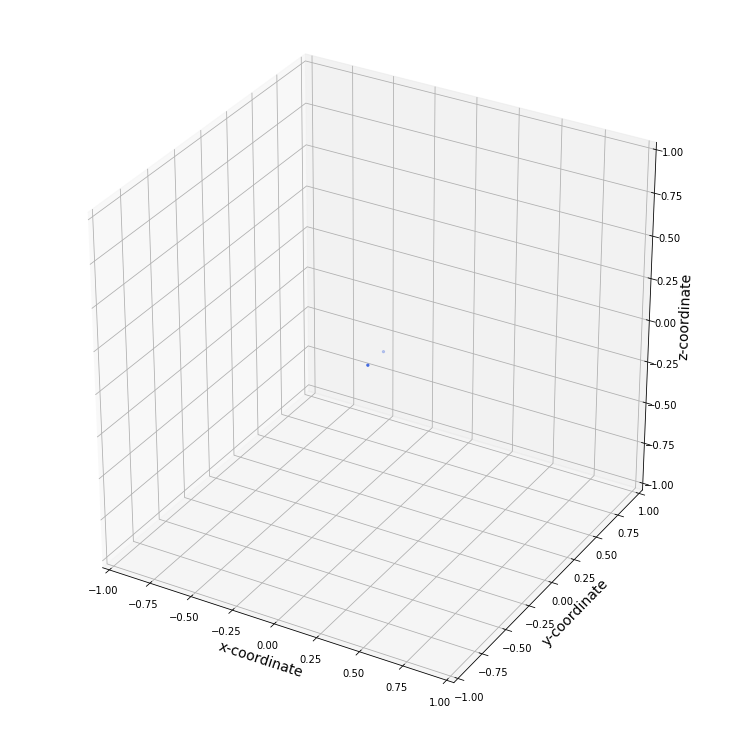

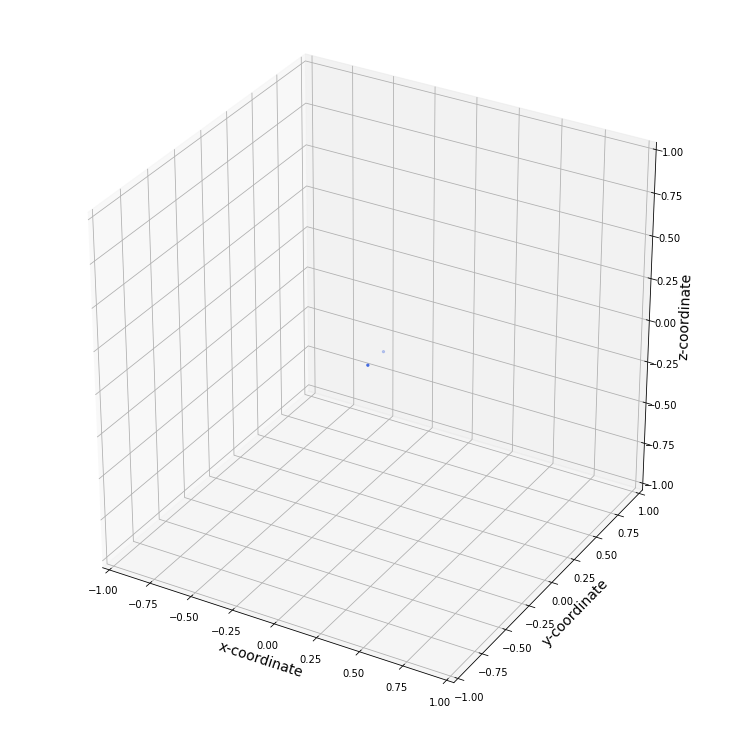

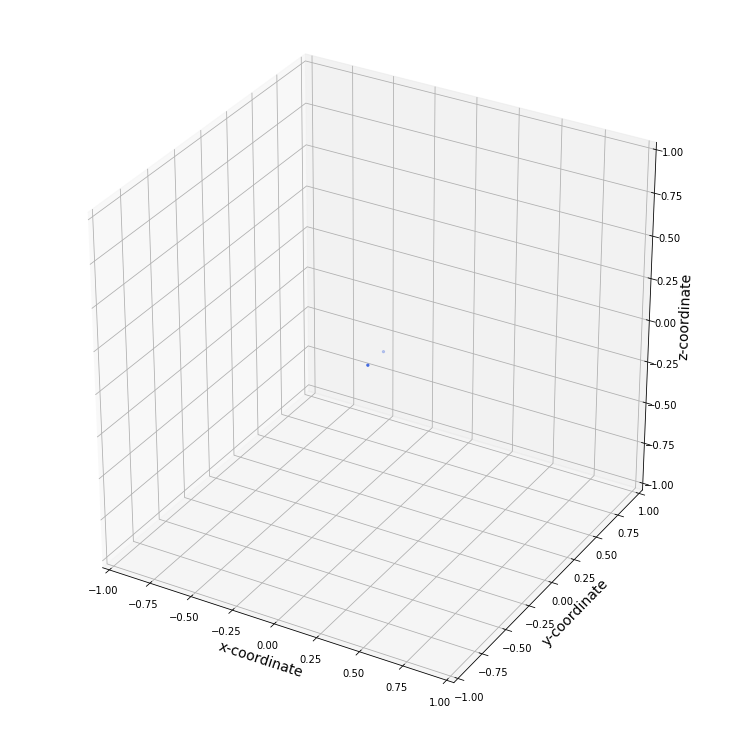

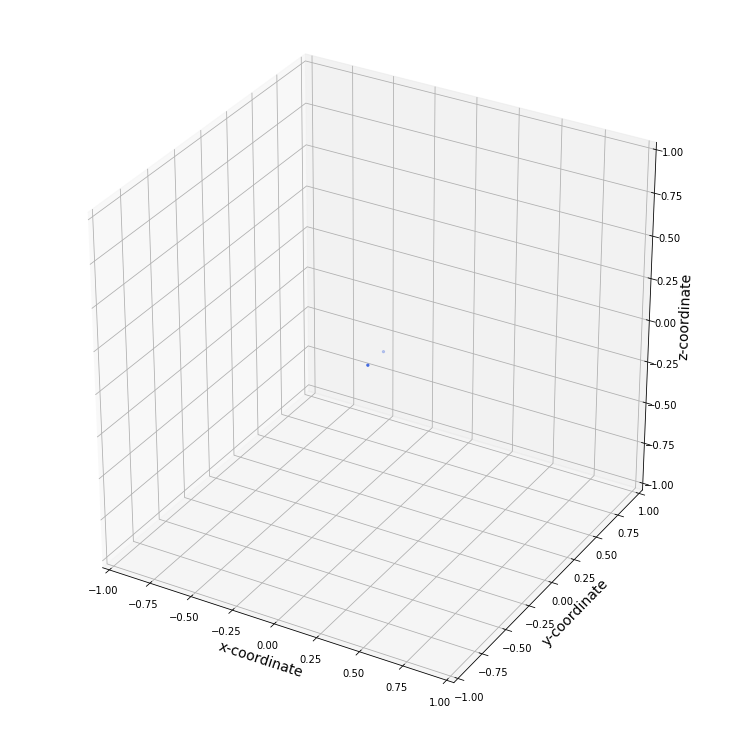

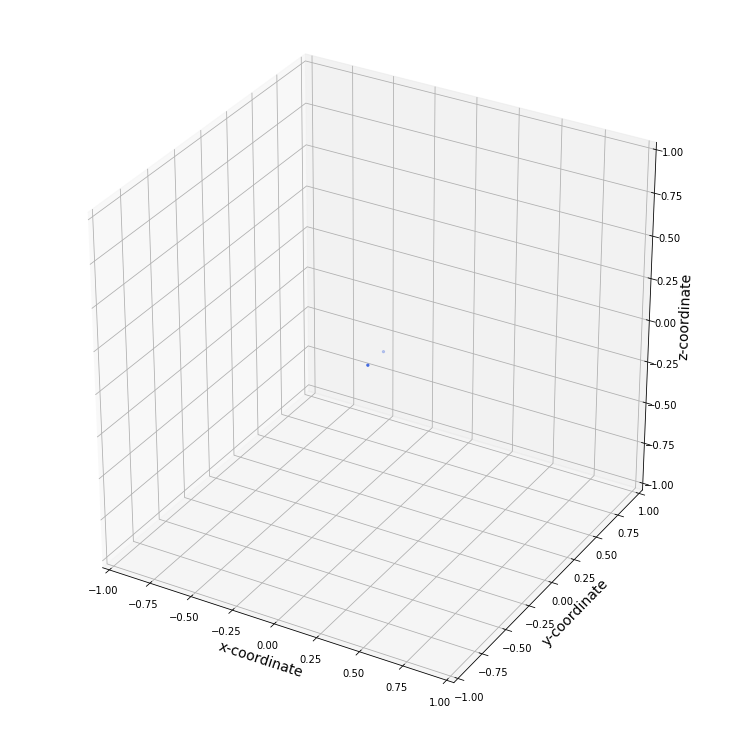

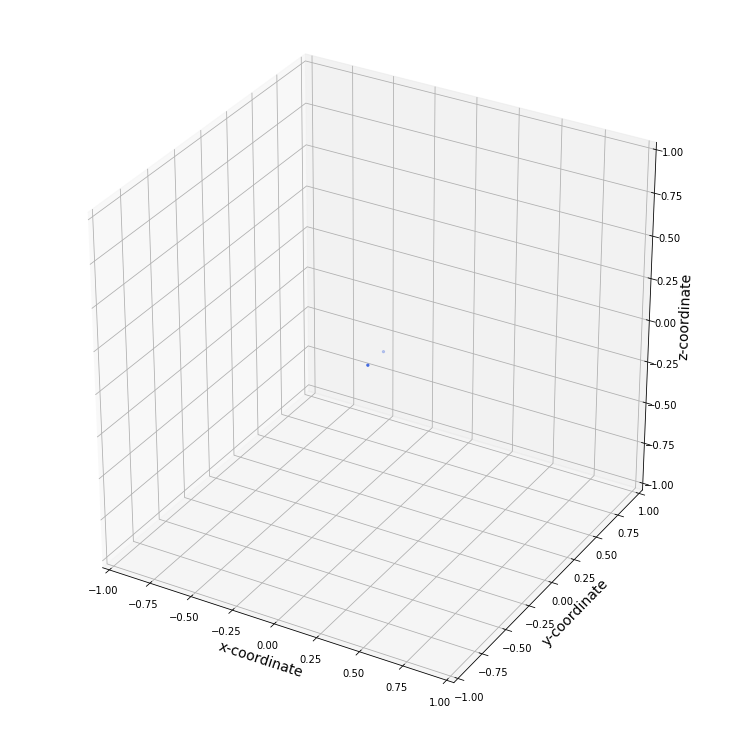

In [45]:
nb_step = 10
for nb in range(nb_step):
    print("Step :",nb+1)
    
    #update v_field
    v_n1 = v_n + 0.5*acc_n*dt
    
    # create list of ptcl for step n(full) and n1(empty)
    x_rho_n = rho_to_x(rho_n)
    x_rho_n1 = x_rho_n*0
    
    #for all ptcl in x_rho_n
    for ptcl in range(len(x_rho_n)):
        i,j,k = x_to_ijk(x_rho_n[ptcl], rho, edge)# get the ptcl position in the matrix
        x_rho_n1[ptcl] = x_rho_n[ptcl] + v_n1[i,j,k]*dt #update that said ptcl position
    
    # Create density matrix rho for step n1
    rho_n1,edge = np.histogramdd(x_rho_n1,bins=size,range=((-1,1),(-1,1),(-1,1)))               
    
    # step n1 becomes step n and n1 is set back to 0
    rho_n = rho_n1
    v_n = v_n1
    rho_n1 = rho_n*0
    v_n1 = v_n*0
    
    # plot the ptcl in a 3D graph
    plot_graph3D(rho_to_x(rho_n),edge,scale_factor = 1000,save=False, show = True, name = "fig",n = nb)
    
    # Compute total potential matrix by convolving the density matrix with the softened potential
    phi_n = sig.fftconvolve(rho_n,greens_f,mode='same')
    
    # Compute the acceleration matrix by taking the gradient of the potential
    acc_n = np.transpose(np.gradient(phi_n))

In [152]:
def plot(bin_edges_x, bin_edges_y, x, y, field, fx, fy, plot_scatter=True, plot_quiver=True, grid=True, cmap="viridis"):
    """
    A useful function for plotting parameters for the nbody assignment
    
    Most variables should be self explanatory.
    
    field should be for example the density field, potential field, forces... Whatever
    you think would be helpful to plot :)
    
    (fx, fy) are only for if you want to quiver plot and should be the force for each particle
    arranged in the same order as (x,y)
    """
    fig,ax = plt.subplots(figsize=(10,10), dpi=100)
    minor_ticks_x = bin_edges_x
    minor_ticks_y = bin_edges_y
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.set(xlim=(minor_ticks_x[0], minor_ticks_x[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    if grid:
        ax.grid(which='minor', alpha=0.75, color='xkcd:grey')
    if plot_scatter:
        scat = ax.scatter(x, y, color='k', s=10)
    cax = ax.imshow(
        field,
        # Extent goes (left, right, bottom, top)
        origin="lower",
        extent=(minor_ticks_x[0], minor_ticks_x[-1], minor_ticks_y[0], minor_ticks_y[-1]), 
        cmap=cmap
    )
    if plot_quiver:
        qax = ax.quiver(
            x, 
            y,
            fx, 
            fy,
            units="x",
            width=0.005*len(bin_edges_x),
            color="w"
        )
    
    plt.show()

In [ ]:
 minx = edge[0][0] #end of each axes
    miny = edge[1][0]
    minz = edge[2][0]
    maxx = edge[0][-1]
    maxy = edge[1][-1]
    maxz = edge[2][-1]
    centerx = (maxx-minx)/2 # center of x axis
    centery = (maxy-miny)/2
    centerz = (maxz-minz)/2